Learn the inter-grid operator ratio for interface problems using multigrid framework,
* Dataset is constructed by changing RHS 
* Restriction and Prolongation operations are followed by a split operation
* Kernels for some part of fields are learned 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshHandler
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet
from FEANet.multigrid import MultiGrid

from Utils import plot
from Data.dataset import RHSDataSet

In [2]:
training_set = RHSDataSet('Data/poisson2d_rhs_17x17.h5', case='train')
test_set = RHSDataSet('Data/poisson2d_rhs_17x17.h5', case='test')

train_dataloader = DataLoader(training_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

In [3]:
linear_tensor_R = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 16.0
linear_tensor_P = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 4.0
linear_ratio = torch.asarray([5.,2.], dtype=torch.float32)

In [4]:
n = 2**4
model = MultiGrid(n, linear_tensor_R, linear_tensor_P, linear_ratio)
rhs = next(iter(train_dataloader))

In [5]:
print(list(model.parameters()))

[Parameter containing:
tensor([5., 2.]), Parameter containing:
tensor([[[[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]],

         [[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]],

         [[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]],

         [[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]],

         [[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]],

         [[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]],

         [[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]],

         [[0.0625, 0.1250, 0.0625],
          [0.1250, 0.2500, 0.1250],
          [0.0625, 0.1250, 0.0625]],

         [[0.0625, 0.1250, 0.0625],
          [0.1250, 0.

0 0.0334150493144989
1 0.012760479934513569
2 0.011302408762276173
3 0.014219479635357857
4 0.01897512376308441
5 0.02503466047346592
6 0.04666735604405403
7 0.4368997812271118
8 5.642215251922607
9 73.20018005371094
10 949.7198486328125
11 12321.9599609375
12 159868.03125
13 2074180.0
14 26911132.0
15 349153504.0
16 4530021376.0
17 58774110208.0
18 762549829632.0
19 9893543149568.0
20 128361045164032.0
21 1665399741480960.0
22 2.16073362210816e+16
23 2.803401432718377e+17
24 3.637219099299283e+18
25 inf
The iteration doesn't converge!


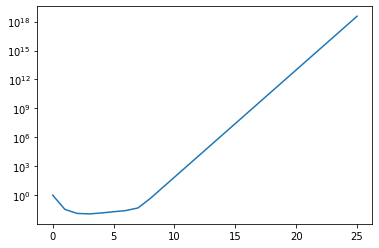

In [7]:
EPS = 5e-5
n_multigrid = 0
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[1].unsqueeze(0))
err_occured = False
while (abs(res) > EPS):
    u = model.iterate(u, model.f)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_multigrid, res)
    n_multigrid += 1

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')

In [8]:
model_dir = 'Model/multigrid_rhs'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
print('Restriction kernel:', model.conv.net.weight[0][0])
print('Interpolation kernel:', model.deconv.net.weight[0][0])
print('Ratio:', model.w[:])

Restriction kernel: tensor([[0.0625, 0.1250, 0.0625],
        [0.1250, 0.2500, 0.1250],
        [0.0625, 0.1250, 0.0625]], grad_fn=<SelectBackward0>)
Interpolation kernel: tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]], grad_fn=<SelectBackward0>)
Ratio: tensor([5., 2.])


In [9]:
def train_one_epoch():
    running_loss = 0.
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad() # zero the gradients for every batch
        u_out = model(data)
        loss_q = model.qm(u_out)
        
        loss_q.backward()
        ## TODO: freeze parts of the grad to be zeros, e.g., param.grad[:,1:] = torch.zeros_like(param.grad[:,1:])
        optimizer.step()
        ## TODO: rewrite the param to be the original weight
        running_loss += loss_q.item()
    
    last_loss = running_loss/(i+1)
    return last_loss

In [25]:
num_epoch = 300
best_vloss = 1_000_000.

qm_train = []
for epoch in range(num_epoch):
    model.train(True)
    avg_q = train_one_epoch()
    print(epoch, avg_q)
    
    # Track best performance, and save the model's state
    mpath = os.path.join(model_dir,'model_multigrid_interface_kernel.pth')
    torch.save(model.state_dict(), mpath)
    qm_train.append(avg_q)

0 7.6466579139232635
1 7.429510086774826
2 7.215534418821335
3 7.008860319852829
4 6.814602911472321
5 6.6165288388729095
6 6.413776367902756
7 6.244303107261658
8 6.0576788783073425
9 5.898732662200928
10 5.732154369354248
11 5.564367830753326
12 5.402377486228943
13 5.258193135261536
14 5.098715752363205
15 4.9514278173446655
16 4.81447046995163
17 4.690913677215576
18 4.546963304281235
19 4.4114720821380615
20 4.29165905714035
21 4.17860147356987
22 4.0484528839588165
23 3.9271458983421326
24 3.8249267041683197
25 3.7053212076425552
26 3.599207729101181
27 3.5030937790870667
28 3.402760773897171
29 3.2941555827856064
30 3.2006055265665054
31 3.1080321073532104
32 3.020230755209923
33 2.9344498366117477
34 2.838829904794693
35 2.7566771060228348
36 2.670077756047249
37 2.5930366069078445
38 2.5176591724157333
39 2.4342577755451202
40 2.357460632920265
41 2.2948583513498306
42 2.221866235136986
43 2.153422638773918
44 2.0855908393859863
45 2.0105681121349335
46 1.9502578899264336
47 1

New ratio: tensor([4.0979, 0.9737], grad_fn=<SliceBackward0>)


Text(0.5, 0, 'epoch')

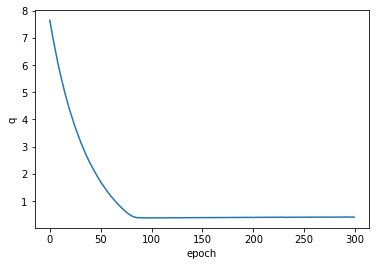

In [26]:
print('New ratio:', model.w[:])
plt.plot(qm_train)
plt.ylabel('q')
plt.xlabel('epoch')

In [10]:
# import the learned model
model.load_state_dict(torch.load(os.path.join(model_dir,'model_multigrid_interface_kernel.pth')))
model.w

Parameter containing:
tensor([4.0979, 0.9737])

In [12]:
EPS = 5e-5
n_multigrid = 0
n = 2**4
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[0].unsqueeze(0))
while (abs(res) > EPS):
    u = model.iterate(u, model.f)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_multigrid, res)
    n_multigrid += 1

print("Solution converges after", n_multigrid, "multi-grid iterations ")

0 0.08122584223747253
1 0.018109390512108803
2 0.005626807454973459
3 0.002053455915302038
4 0.000800775655079633
5 0.0003218300989829004
6 0.00013147442950867116
7 5.3818803280591965e-05
8 2.2844185878057033e-05
Solution converges after 9 multi-grid iterations 


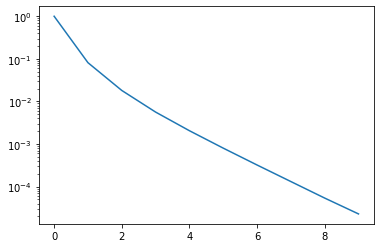

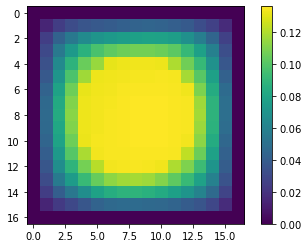

In [13]:
plt.plot(res_arr)
plt.yscale('log')
plot.plot_field(u.detach())

In [14]:
# Test the multigrid iteration
class mgTest(MultiGrid):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, inter_model, n = 64):
        super(mgTest, self).__init__(n, linear_tensor_R, linear_tensor_P, linear_ratio)

        self.size = 2
        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1, dtype=np.float32) # grid number is n+1
        self.y = np.linspace(-1,1,n+1, dtype=np.float32)
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='xy')
        self.solution = []

        self.w = inter_model.w
        self.conv = inter_model.conv
        self.deconv = inter_model.deconv
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)
        self.w.requires_grad_(False)
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = np.ones_like(self.xx)
        self.grids[0].f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest right hand side with the original rhs
    
    def solve(self):
        '''Return error and residual array'''
        EPS = 5e-5
        n_Vcycle = 0
        self.grids[0].v = torch.zeros((1, 1, self.n+1, self.n+1), requires_grad=False, dtype=torch.float32)
        e_Vcycle, res = 1, 1
        e_arr_Vcycle = [e_Vcycle]
        res_arr_Vcycle = [res]
        err_occured = False
        while (res > EPS):
            u_prev = self.grids[0].v 
            self.grids[0].v = self.iterate(self.grids[0].v,self.grids[0].f)
            e_Vcycle = torch.sqrt(torch.sum((self.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((self.grids[0].v) ** 2)).item()
            e_arr_Vcycle.append(e_Vcycle)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
            res_arr_Vcycle.append(res)
            print(e_Vcycle, res)
            n_Vcycle += 1
            if(res == torch.inf or math.isnan(res)):
                err_occured = True
                break

        if(err_occured):
            print("The iteration doesn't converge!")
        else:
            print("Solution converges after", n_Vcycle, "V-cycle iterations with relative error of", e_Vcycle)
        return e_arr_Vcycle, res_arr_Vcycle

1.0 0.09073875099420547
0.035194322773794036 0.030900312587618828
0.009194440937153341 0.01274152658879757
0.0033744771592073954 0.005685718264430761
0.0014576641510243866 0.002603311324492097
0.0006644431293058143 0.0012069797376170754
0.0003124710478399769 0.0005637892172671854
0.00014436536945639796 0.0002637876314111054
6.51663378893929e-05 0.00012289603182580322
3.4324243194481025e-05 5.8284305850975215e-05
1.3535356307976437e-05 2.7691176001098938e-05
Solution converges after 11 V-cycle iterations with relative error of 1.3535356307976437e-05


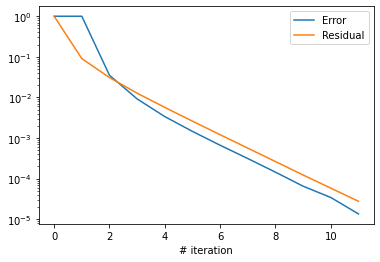

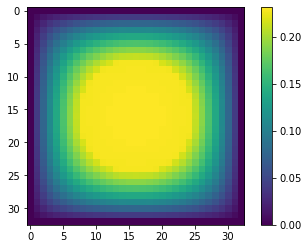

In [15]:
# Multigrid implementation
n = 2**5
prob_mg = mgTest(model, n)

e_arr_Vcycle, res_arr_Vcycle = prob_mg.solve()

plt.plot(e_arr_Vcycle, label='Error')
plt.plot(res_arr_Vcycle, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

plot.plot_field(prob_mg.grids[0].v.detach())

In [16]:
def compute_q(res_arr):
    return np.power(res_arr[9]/res_arr[6], 1.0/4)

print("q is: ", compute_q(res_arr_Vcycle))

q is:  0.5648842555047452
